In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_white_gaussian_noise(mean, std, num_samples):
    samples = np.random.normal(mean, std, size=num_samples)
    plt.plot(samples)
    plt.show()

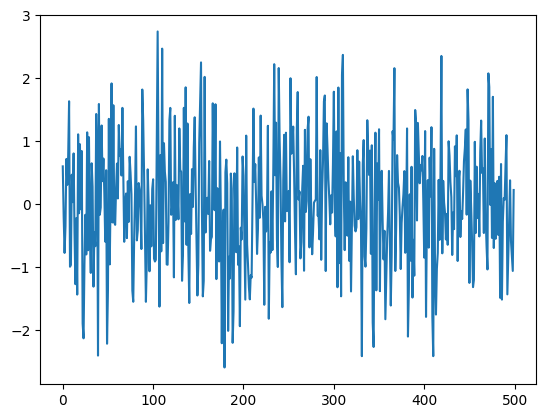

In [3]:
generate_white_gaussian_noise(0, 1, 500)

In [4]:
mean = [0, 0, 1, -1]
cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
x0 = np.random.multivariate_normal(mean, cov, 1).T
plt.plot(x, y, '.')
plt.show()

NameError: name 'x' is not defined

In [ ]:
x0.shape

(4, 1)

In [5]:
plt.plot(x)
plt.plot(y)
plt.show()

NameError: name 'x' is not defined

In [6]:
N = 100
dt = 0.1

In [7]:
def state_system(t):
    A = [[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]]
    mean = [0, 0, 1, -1]
    cov = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    mean2 = [0, 0, 0, 0]
    cov2 = [[(dt**3)/3, 0, (dt**2)/2, 0], [0, (dt**3)/3, 0, (dt**2)/2], [(dt**2)/2, 0, dt, 0], [0, (dt**2)/2, 0, dt]]
    L = [np.random.multivariate_normal(mean, cov, 1).T]
    for i in range(1, t):
        L.append(np.dot(A, L[i-1]) + np.random.multivariate_normal(mean2, cov2, 1).T)
    return L

In [8]:
state_system(N)

[array([[-1.72726461],
        [-0.309149  ],
        [-0.49182012],
        [-1.68851046]]),
 array([[-1.78615597],
        [-0.47194599],
        [-0.82809921],
        [-1.57702217]]),
 array([[-1.87813347],
        [-0.62306708],
        [-1.08920281],
        [-1.5273175 ]]),
 array([[-1.99871261],
        [-0.78452342],
        [-1.00776491],
        [-1.6352287 ]]),
 array([[-2.10983005],
        [-0.98019598],
        [-1.34116084],
        [-2.13250921]]),
 array([[-2.26838307],
        [-1.18926268],
        [-1.72685541],
        [-2.19190478]]),
 array([[-2.43546041],
        [-1.4316022 ],
        [-1.74167139],
        [-2.88452057]]),
 array([[-2.65281161],
        [-1.73682746],
        [-2.45928413],
        [-2.88863902]]),
 array([[-2.90996526],
        [-2.02262532],
        [-2.44908082],
        [-2.70345509]]),
 array([[-3.1570815 ],
        [-2.30903448],
        [-2.47462966],
        [-2.91106389]]),
 array([[-3.4014076 ],
        [-2.59329065],
        [-2.30

In [9]:
def measurements(t):
    mean = [0, 0]
    cov = [[4, 0], [0, 4]]
    return state_system(t)[0:2], state_system(t)[0:2] + np.random.multivariate_normal(mean, cov, 1).T

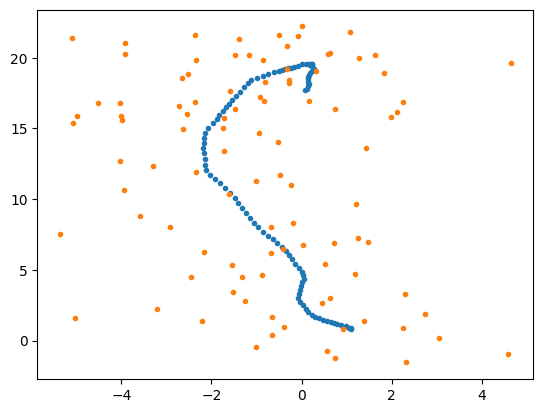

In [39]:
X1=[]
Y2=[]
X2=[]
Y1=[]
X3=[]
X4=[]
V1=[]
V2=[]
mean = [0, 0]
cov = [[4, 0], [0, 4]]
L = state_system(N)
for i in range(len(L)):
    x,y = L[i], L[i][0:2] + np.random.multivariate_normal(mean, cov, 1).T
    X1.append(x[0])
    X2.append(x[1])
    X3.append(x[2])
    X4.append(x[3])
    Y1.append(y[0])
    Y2.append(y[1])
    V1.append((Y1[i]-Y1[i-1])/dt)
    V2.append((Y2[i]-Y2[i-1])/dt)
plt.plot(X1,X2,'.') 
plt.plot(Y1,Y2, '.')
plt.show()

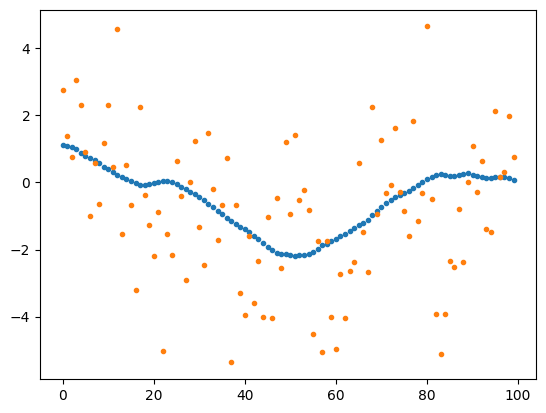

In [40]:
plt.plot(X1, '.') 
plt.plot(Y1, '.')
plt.show()

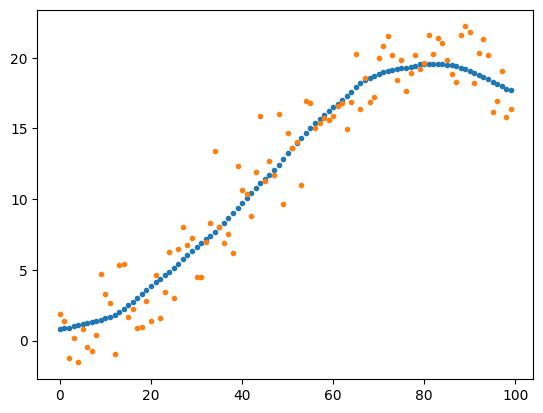

In [41]:
plt.plot(X2,'.') 
plt.plot(Y2,'.')
plt.show()

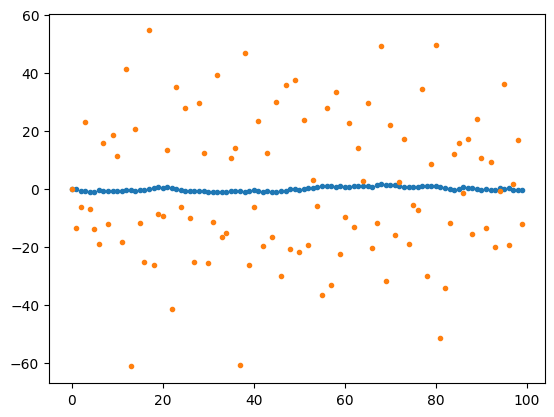

In [42]:
plt.plot(X3,'.') 
plt.plot(V1,'.')
plt.show()

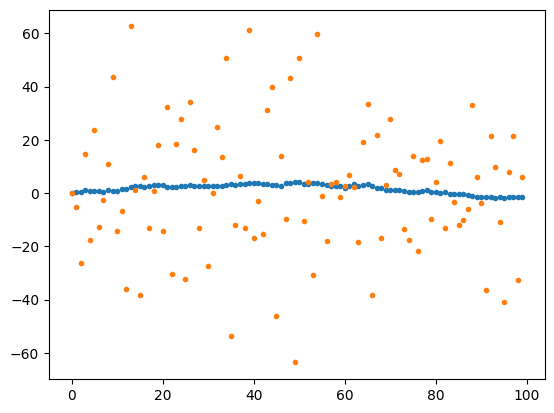

In [43]:
plt.plot(X4,'.') 
plt.plot(V2,'.')
plt.show()